In [72]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torch.utils.data import DataLoader
from torchvision.models import ResNet18_Weights, ResNet50_Weights
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, models
import time
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import copy
import random
import gradio
from collections import Counter

# Primary data analysis

### Let's look at several examples from our dataset

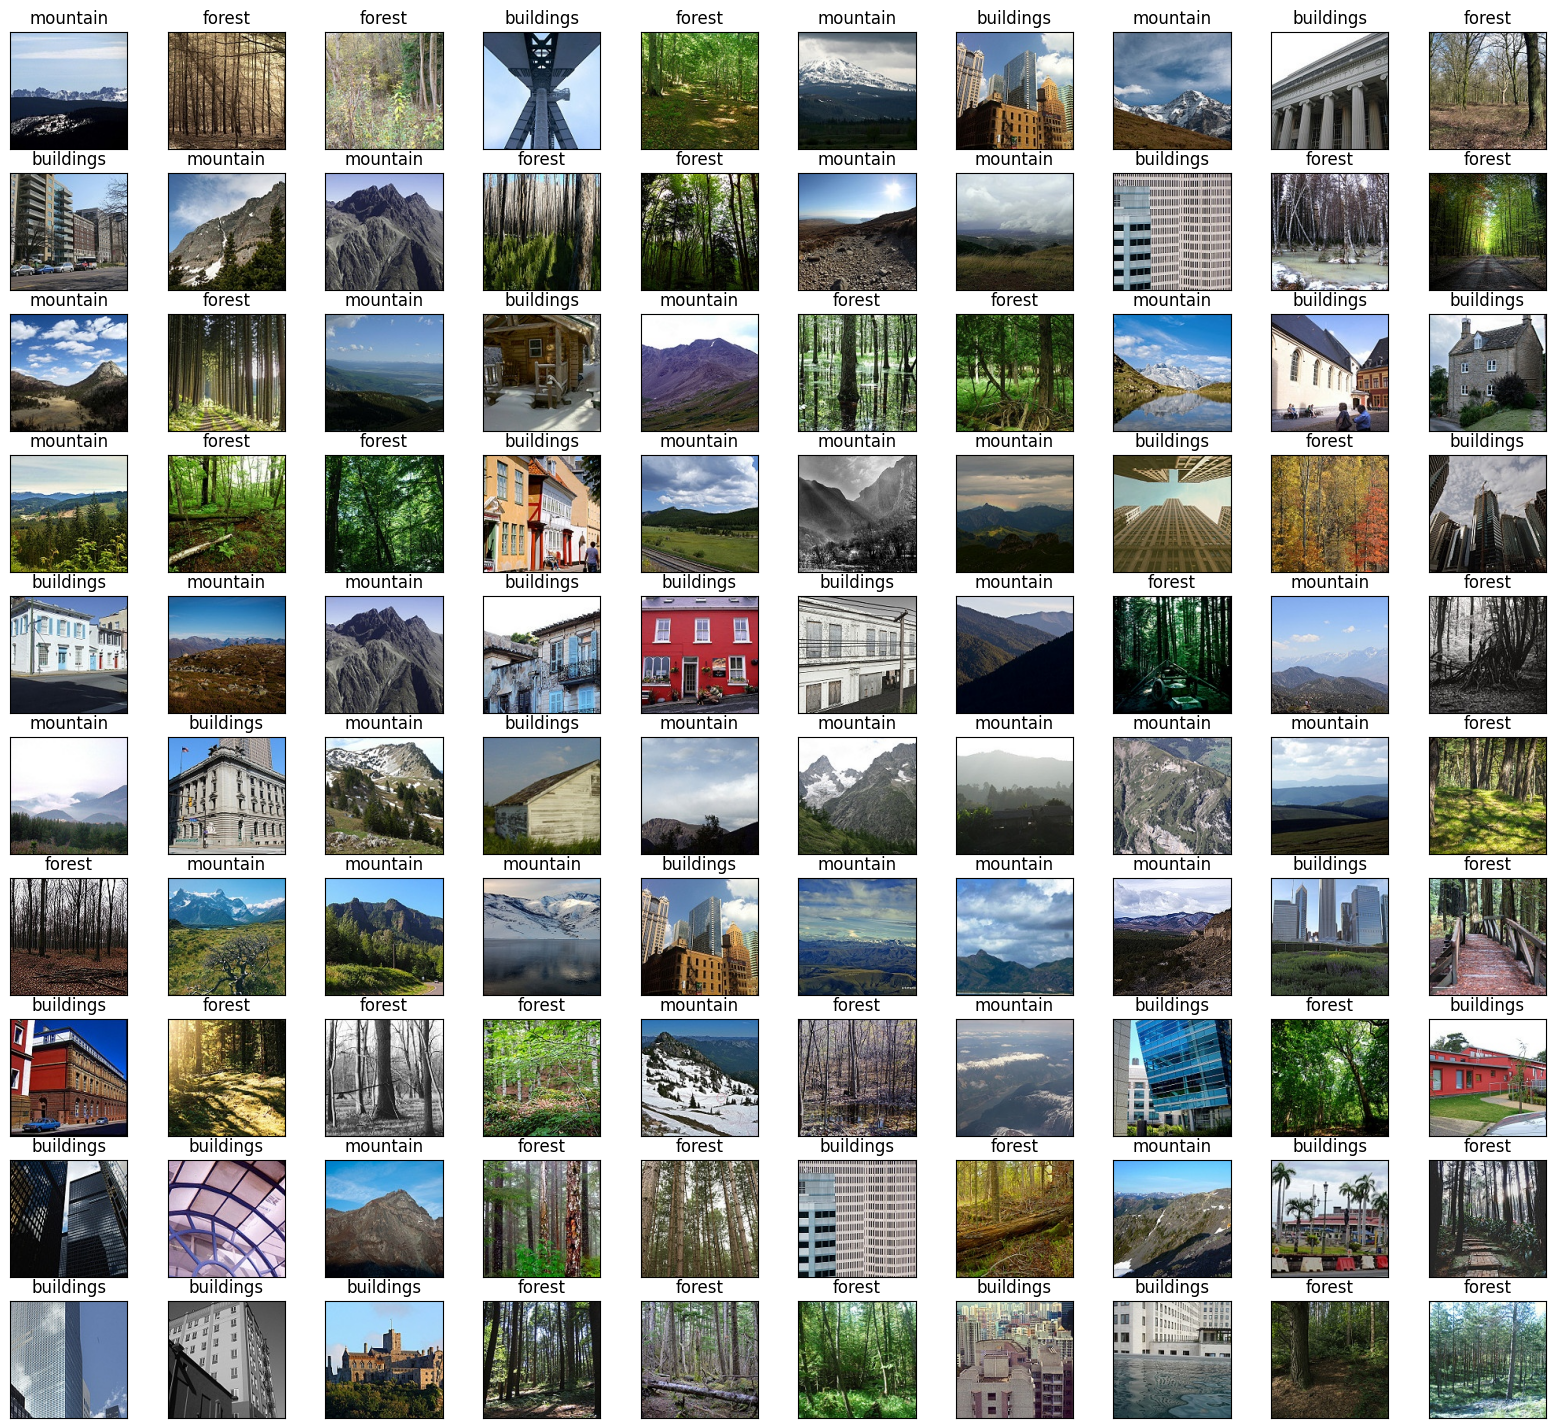

In [69]:
fig = plt.figure(figsize=(20, 18))
visualize_dataset = torchvision.datasets.ImageFolder(root='./train/')
rows, columns = 10, 10
rand_indeces = np.random.randint(low=0, high=len(visualize_dataset), size=(rows*columns,))

images = []
labels = []

for i in rand_indeces:
    img, class_ = visualize_dataset[i]
    images.append(img)
    labels.append(visualize_dataset.classes[class_])

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{labels[i-1]}")
plt.savefig('samples.png') 

## As we can see from the visualization of part of our dataset, the pictures are quite different.

### However, we have some similarities:

#### - There are forested mountains. That is, the picture is classified as "Mountains", but also has a forest, which can reduce the accuracy of the model.

#### - For the most part, buildings are not like other classes. But there may be similarities in color. It is unlikely to have a significant impact on the quality of the model.

#### - Forests do not always grow on a flat surface, there is a possibility that the model will perceive it as "Mountains".

### **Let's take a look at our classes and how balanced they are**

In [47]:
def number_images(dataset: str):
    classes = {'Mountain': len(os.listdir(f'./{dataset}/mountain')),
               'Forest': len(os.listdir(f'./{dataset}/forest')),
               'Building': len(os.listdir(f'./{dataset}/buildings'))}
    plt.bar(classes.keys(), classes.values(), width = .5)
    plt.title(f"Number of Images by Class in {dataset}")
    plt.xlabel('Class Name')
    plt.ylabel('# Images')
    
    return classes

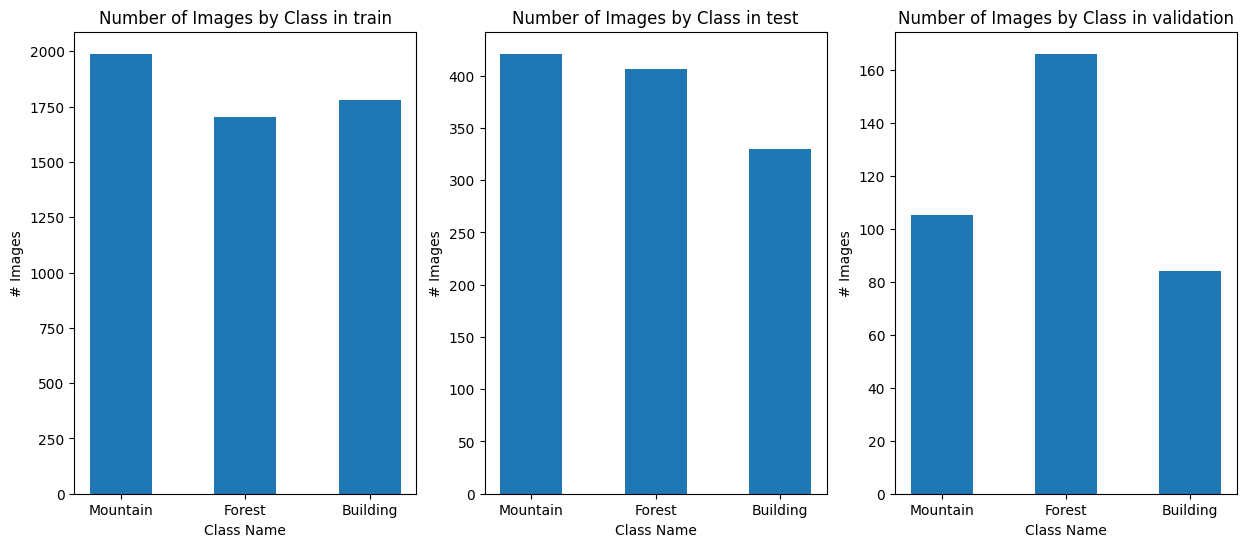

In [70]:
plt.figure(1, figsize=(15, 6))
plt.subplot(131)
number_images('train')
plt.subplot(132)
number_images('test')
plt.subplot(133)
number_images('validation')
plt.plot()
plt.savefig('number_of_images_per_class.png') 

# Imbalance

#### As we can see from the graphs, we have an imbalance in the number of pictures between classes in each dataset.

#### If in the training dataset the imbalance does not look critical, in the test and validation the difference is large, which can affect the final result.

#### These irregularities will have to be corrected.

#### **Let's fix this and start building a neural network**

In [49]:
# Function to balance our classes
def undersample_data(dataset, target_class_size):
    class_counts = Counter(dataset.targets)
    undersampled_data = []

    for class_label, count in class_counts.items():
        if count > target_class_size:
            indices = [i for i, label in enumerate(dataset.targets) if label == class_label]
            samples = random.sample(indices, target_class_size)
            undersampled_data.extend(samples)
        else:
            undersampled_data.extend([i for i, label in enumerate(dataset.targets) if label == class_label])

    return undersampled_data

In [50]:
train_transform = transforms.Compose([
                       transforms.Resize(64),
                       transforms.RandomCrop(64),
                       transforms.ToTensor()
                   ])

test_transform = transforms.Compose([
                       transforms.Resize(64),
                       transforms.RandomCrop(64),
                       transforms.ToTensor()
                   ])

val_transform = transforms.Compose([
                       transforms.Resize(64),
                       transforms.RandomCrop(64),
                       transforms.ToTensor()
                   ])

train_dataset = torchvision.datasets.ImageFolder(
    root='./train/',
    transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(
    root='./test/',
    transform=test_transform)
val_dataset = torchvision.datasets.ImageFolder(
    root='./validation/',
    transform=val_transform)

# Taking some part of each dataset to have same number of images for each class
undersampled_train = undersample_data(train_dataset, 1600)
undersampled_test = undersample_data(test_dataset, 320)
undersampled_val = undersample_data(val_dataset, 80)

undersampled_train_dataset = torch.utils.data.Subset(train_dataset, undersampled_train)
train_loader = DataLoader(undersampled_train_dataset, batch_size=64, shuffle=True, num_workers=3, pin_memory=True)

undersampled_test_dataset = torch.utils.data.Subset(test_dataset, undersampled_test)
test_loader = DataLoader(undersampled_test_dataset, batch_size=32, shuffle=False, num_workers=3)

undersampled_val_dataset = torch.utils.data.Subset(val_dataset, undersampled_val)
val_loader = DataLoader(undersampled_val_dataset, batch_size=8, shuffle=False, num_workers=1)

In [51]:
# Function to get mean value / standard deviation value

def get_mean_std(data_loader):
    sum_, squared_sum, batches = 0, 0, 0
    for data, _ in data_loader:
        sum_ += torch.mean(data, dim=([0, 2, 3]))
        squared_sum += torch.mean(data ** 2, dim=([0, 2, 3]))
        batches += 1
    
    mean = sum_ / batches
    std = (squared_sum / batches - mean ** 2) ** 0.5
    return mean, std

In [52]:
mean, std = get_mean_std(train_loader)
mean, std

(tensor([0.4051, 0.4312, 0.4044]), tensor([0.2452, 0.2463, 0.2865]))

In [53]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])


test_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])


val_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

In [54]:
train_transform

Compose(
    RandomResizedCrop(size=(64, 64), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=tensor([0.4051, 0.4312, 0.4044]), std=tensor([0.2452, 0.2463, 0.2865]))
)

In [55]:
test_transform

Compose(
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=tensor([0.4051, 0.4312, 0.4044]), std=tensor([0.2452, 0.2463, 0.2865]))
)

In [56]:
val_transform

Compose(
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=tensor([0.4051, 0.4312, 0.4044]), std=tensor([0.2452, 0.2463, 0.2865]))
)

In [57]:
train_dataset = torchvision.datasets.ImageFolder(
    root='./train/',
    transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(
    root='./test/',
    transform=test_transform)
val_dataset = torchvision.datasets.ImageFolder(
    root='./validation/',
    transform=val_transform)

# Taking some part of each dataset to have same number of images for each class
undersampled_train = undersample_data(train_dataset, 1600)
undersampled_test = undersample_data(test_dataset, 320)
undersampled_val = undersample_data(val_dataset, 80)

undersampled_train_dataset = torch.utils.data.Subset(train_dataset, undersampled_train)
train_loader = DataLoader(undersampled_train_dataset, batch_size=64, shuffle=True, num_workers=3, pin_memory=True)

undersampled_test_dataset = torch.utils.data.Subset(test_dataset, undersampled_test)
test_loader = DataLoader(undersampled_test_dataset, batch_size=32, shuffle=False, num_workers=3)

undersampled_val_dataset = torch.utils.data.Subset(val_dataset, undersampled_val)
val_loader = DataLoader(undersampled_val_dataset, batch_size=8, shuffle=False, num_workers=1)

In [71]:
# Building the Neural Network 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.25)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3136, 128)
        self.fc2 = nn.Softplus(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        output = self.fc2(x)

        return output
    
    

def main():
    since = time.time()
    torch.manual_seed(1337)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Net().to(device)
    
    epochs = 10
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    scheduler = StepLR(optimizer, step_size=1, gamma=0.5)
    for epoch in range(1, epochs + 1):
        
        # Training the model
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
                
        
        # Testing the model
        
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += loss_fn(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        
        
        scheduler.step()
    
    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60}m {round((time_elapsed % 60), 2)}s')
        
    torch.save(model, 'model.pt')
    torch.save(model.state_dict(), 'model_state_dict.pt')
    
    return model
    
if __name__ == '__main__':
    model = main()

Train Epoch: 1 [0/4800 (0%)]	Loss: 5.214530

Test set: Average loss: 0.0223, Accuracy: 787/960 (82%)

Train Epoch: 2 [0/4800 (0%)]	Loss: 0.943288

Test set: Average loss: 0.0079, Accuracy: 888/960 (92%)

Train Epoch: 3 [0/4800 (0%)]	Loss: 0.378709

Test set: Average loss: 0.0085, Accuracy: 876/960 (91%)

Train Epoch: 4 [0/4800 (0%)]	Loss: 0.381876

Test set: Average loss: 0.0070, Accuracy: 892/960 (93%)

Train Epoch: 5 [0/4800 (0%)]	Loss: 0.444421

Test set: Average loss: 0.0064, Accuracy: 900/960 (94%)

Train Epoch: 6 [0/4800 (0%)]	Loss: 0.210498

Test set: Average loss: 0.0070, Accuracy: 890/960 (93%)

Train Epoch: 7 [0/4800 (0%)]	Loss: 0.434599

Test set: Average loss: 0.0066, Accuracy: 896/960 (93%)

Train Epoch: 8 [0/4800 (0%)]	Loss: 0.287199

Test set: Average loss: 0.0065, Accuracy: 902/960 (94%)

Train Epoch: 9 [0/4800 (0%)]	Loss: 0.275819

Test set: Average loss: 0.0065, Accuracy: 901/960 (94%)

Train Epoch: 10 [0/4800 (0%)]	Loss: 0.193224

Test set: Average loss: 0.0065, Accu

Accuracy: 91.67%


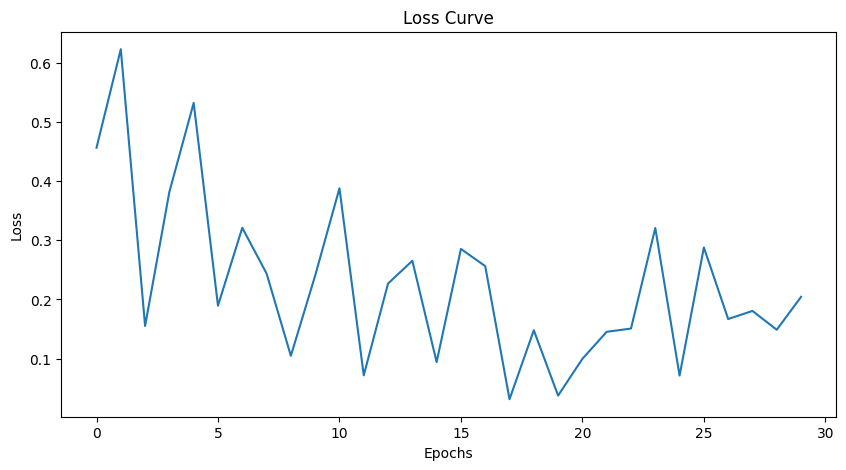

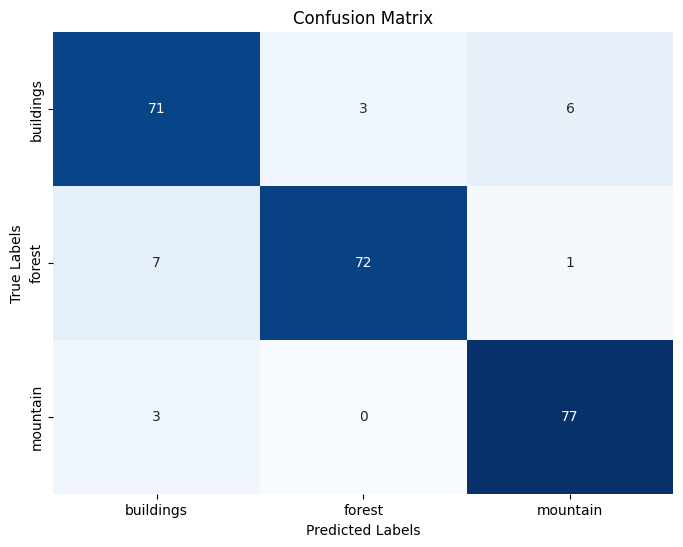

In [78]:
# Making graphs of Loss and Confusion Matrix
loaded_model = torch.load('model.pt')
loaded_model.load_state_dict(torch.load('model_state_dict.pt'))
loaded_model.eval()

criterion = nn.CrossEntropyLoss()

all_preds = []
all_labels = []
losses = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = loaded_model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        losses.append(loss.item())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('loss.png')
plt.show()

confusion = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['buildings', 'forest', 'mountain'], yticklabels=['buildings', 'forest', 'mountain'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('conf_matrix.png')
plt.show()

In [61]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([32, 3, 3, 3])
conv1.bias 	 torch.Size([32])
bn1.weight 	 torch.Size([32])
bn1.bias 	 torch.Size([32])
bn1.running_mean 	 torch.Size([32])
bn1.running_var 	 torch.Size([32])
bn1.num_batches_tracked 	 torch.Size([])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
bn2.weight 	 torch.Size([64])
bn2.bias 	 torch.Size([64])
bn2.running_mean 	 torch.Size([64])
bn2.running_var 	 torch.Size([64])
bn2.num_batches_tracked 	 torch.Size([])
fc1.weight 	 torch.Size([128, 3136])
fc1.bias 	 torch.Size([128])


# Results

#### After selecting the hyperparameters, it was possible to achieve model accuracy of 92-94%.

#### However, on the validation set, the accuracy dropped to 92%.

#### Let's compare this model with some  pre-trained models.

#### We'll start with ResNet18

In [23]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [24]:
train_dataset = torchvision.datasets.ImageFolder(
    root='./train/',
    transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(
    root='./test/',
    transform=test_transform)
val_dataset = torchvision.datasets.ImageFolder(
    root='./validation/',
    transform=val_transform)

# Taking some part of each dataset to have same number of images for each class
undersampled_train = undersample_data(train_dataset, 1600)
undersampled_test = undersample_data(test_dataset, 320)
undersampled_val = undersample_data(val_dataset, 80)

undersampled_train_dataset = torch.utils.data.Subset(train_dataset, undersampled_train)
train_loader = DataLoader(undersampled_train_dataset, batch_size=64, shuffle=True, num_workers=3, pin_memory=True)

undersampled_test_dataset = torch.utils.data.Subset(test_dataset, undersampled_test)
test_loader = DataLoader(undersampled_test_dataset, batch_size=32, shuffle=False, num_workers=3)

undersampled_val_dataset = torch.utils.data.Subset(val_dataset, undersampled_val)
val_loader = DataLoader(undersampled_val_dataset, batch_size=8, shuffle=False, num_workers=1)

In [25]:
num_classes = len(train_dataset.classes)

num_epochs = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

for param in resnet.parameters():
    param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)
print(f"{num_ftrs = }")

num_ftrs = 512


In [74]:
# Function to check accuracy of pre-trained model
def check_accuracy(loader, md):
    num_correct = 0
    num_samples = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = md.to(device)
    
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 

In [26]:
# Training model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(resnet.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                resnet.train()
            else:
                resnet.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = resnet(inputs)
                    y_pred_proba = torch.softmax(outputs, dim=1)
                    y_pred = y_pred_proba.argmax(dim=1)

                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
     
                running_corrects += torch.sum(y_pred == labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(resnet.state_dict())
          

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    resnet.load_state_dict(best_model_wts)
    return resnet

In [27]:
dataloaders_dict = {
    "train": train_loader,
    "val": test_loader,
}

resnet = resnet.to(device)
optimizer_ft = optim.Adam(params=resnet.parameters())

In [28]:
# Testing model
criterion = nn.CrossEntropyLoss()

resnet = train_model(resnet, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.2926 Acc: 0.9263
val Loss: 0.0724 Acc: 0.9917

Epoch 1/14
----------
train Loss: 0.0740 Acc: 0.9877
val Loss: 0.0426 Acc: 0.9938

Epoch 2/14
----------
train Loss: 0.0532 Acc: 0.9900
val Loss: 0.0324 Acc: 0.9938

Epoch 3/14
----------
train Loss: 0.0409 Acc: 0.9917
val Loss: 0.0274 Acc: 0.9938

Epoch 4/14
----------
train Loss: 0.0427 Acc: 0.9906
val Loss: 0.0250 Acc: 0.9938

Epoch 5/14
----------
train Loss: 0.0350 Acc: 0.9921
val Loss: 0.0208 Acc: 0.9948

Epoch 6/14
----------
train Loss: 0.0322 Acc: 0.9923
val Loss: 0.0202 Acc: 0.9938

Epoch 7/14
----------
train Loss: 0.0337 Acc: 0.9919
val Loss: 0.0173 Acc: 0.9948

Epoch 8/14
----------
train Loss: 0.0258 Acc: 0.9925
val Loss: 0.0206 Acc: 0.9948

Epoch 9/14
----------
train Loss: 0.0290 Acc: 0.9925
val Loss: 0.0158 Acc: 0.9958

Epoch 10/14
----------
train Loss: 0.0261 Acc: 0.9925
val Loss: 0.0154 Acc: 0.9948

Epoch 11/14
----------
train Loss: 0.0279 Acc: 0.9925
val Loss: 0.0166 Acc: 0.9938

Ep

In [29]:
check_accuracy(val_loader, resnet)

Got 240 / 240 with accuracy 100.00


### As we can see, the simple trained model shows better results

### Almost 100% model accuracy on testing and validation

### For the completeness of the experiment, let's try another model (ResNet50), which is more complex

### Then we will compare all three models

In [30]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [31]:
train_dataset = torchvision.datasets.ImageFolder(
    root='./train/',
    transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(
    root='./test/',
    transform=test_transform)
val_dataset = torchvision.datasets.ImageFolder(
    root='./validation/',
    transform=val_transform)

# Taking some part of each dataset to have same number of images for each class
undersampled_train = undersample_data(train_dataset, 1600)
undersampled_test = undersample_data(test_dataset, 320)
undersampled_val = undersample_data(val_dataset, 80)

undersampled_train_dataset = torch.utils.data.Subset(train_dataset, undersampled_train)
train_loader = DataLoader(undersampled_train_dataset, batch_size=64, shuffle=True, num_workers=3, pin_memory=True)

undersampled_test_dataset = torch.utils.data.Subset(test_dataset, undersampled_test)
test_loader = DataLoader(undersampled_test_dataset, batch_size=32, shuffle=False, num_workers=3)

undersampled_val_dataset = torch.utils.data.Subset(val_dataset, undersampled_val)
val_loader = DataLoader(undersampled_val_dataset, batch_size=8, shuffle=False, num_workers=1)

In [32]:
num_classes = len(train_dataset.classes)

num_epochs = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)

for param in resnet.parameters():
    param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)
print(f"{num_ftrs = }")

num_ftrs = 512


In [33]:
dataloaders_dict = {
    "train": train_loader,
    "val": test_loader,
}

resnet50 = resnet50.to(device)
optimizer_ft = optim.Adam(params=resnet50.parameters())

In [34]:
# Testing model
criterion = nn.CrossEntropyLoss()

resnet50 = train_model(resnet50, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 1.2043 Acc: 0.3183
val Loss: 1.2153 Acc: 0.3240

Epoch 1/14
----------
train Loss: 1.2032 Acc: 0.3187
val Loss: 1.2177 Acc: 0.3260

Epoch 2/14
----------
train Loss: 1.2052 Acc: 0.3142
val Loss: 1.2230 Acc: 0.3240

Epoch 3/14
----------
train Loss: 1.2053 Acc: 0.3144
val Loss: 1.2214 Acc: 0.3198

Epoch 4/14
----------
train Loss: 1.2041 Acc: 0.3150
val Loss: 1.2157 Acc: 0.3260

Epoch 5/14
----------
train Loss: 1.2046 Acc: 0.3194
val Loss: 1.2200 Acc: 0.3219

Epoch 6/14
----------
train Loss: 1.2082 Acc: 0.3100
val Loss: 1.2080 Acc: 0.3333

Epoch 7/14
----------
train Loss: 1.2028 Acc: 0.3156
val Loss: 1.2202 Acc: 0.3177

Epoch 8/14
----------
train Loss: 1.2047 Acc: 0.3162
val Loss: 1.2175 Acc: 0.3240

Epoch 9/14
----------
train Loss: 1.2052 Acc: 0.3077
val Loss: 1.2248 Acc: 0.3323

Epoch 10/14
----------
train Loss: 1.2073 Acc: 0.3108
val Loss: 1.2151 Acc: 0.3292

Epoch 11/14
----------
train Loss: 1.1999 Acc: 0.3225
val Loss: 1.2214 Acc: 0.3229

Ep

In [35]:
check_accuracy(val_loader, resnet50)

Got 0 / 240 with accuracy 0.00


# Comparison

### From experiments on three models with our dataset, we can conclude that ResNet18 gives the best results.

#### Our CNN - Accuracy = 94%, Loss = 0.0065

#### ResNet18 - Accuracy = 99-100%, Loss = 0.0157

#### ResNet50 - Accuracy = 0-33%, Loss = 1.21

# Running the model

### Play the cell below

### When the fields for uploading images appear, select the desired one

### Pressing the start button to start the model

In [80]:
load_model = torch.load('model.pt')
load_model.eval()
labels = ['buildings', 'forest', 'mountain']

mean = [0.4051, 0.4312, 0.4044]
std = [0.2452, 0.2463, 0.2865]
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  
])

def predict(img):
    x = transform(Image.fromarray(img)).unsqueeze(0) 
    with torch.no_grad():
        outp = load_model(x)

        pred = outp.argmax(dim=1).item()
    return labels[pred]

demo = gradio.Interface(fn=predict, inputs="image", outputs="label")

if __name__ == "__main__":
    demo.launch()

Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.
